In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        553M         23G        1.2M        1.8G         24G
Swap:            0B          0B          0B


# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp_patches
import pandas as pd

## Get Files

In [ ]:
url = 'https://drive.google.com/file/d/1JrazOX7wk_uMCyBzdhwJeoEPqEjioakG/view?usp=sharing'
batch_name = '301121_imu_zero_velocity'

In [ ]:
!ls "{batch_name}.tar.xz" 2>/dev/null || (python -m pip install gdown --upgrade > /dev/null && gdown --fuzzy "{url}")

Downloading...
From: https://drive.google.com/uc?id=1JrazOX7wk_uMCyBzdhwJeoEPqEjioakG
To: /content/301121_imu_zero_velocity.tar.xz
100% 176k/176k [00:00<00:00, 83.7MB/s]


In [ ]:
!ls "{batch_name}" 2>/dev/null 1>/dev/null || tar xvf "{batch_name}.tar.xz"

301121_imu_zero_velocity/
301121_imu_zero_velocity/fast_1/
301121_imu_zero_velocity/fast_1/imu.csv
301121_imu_zero_velocity/fast_1/times.log
301121_imu_zero_velocity/fast_2/
301121_imu_zero_velocity/fast_2/imu.csv
301121_imu_zero_velocity/fast_2/times.log
301121_imu_zero_velocity/slow_1/
301121_imu_zero_velocity/slow_1/imu.csv
301121_imu_zero_velocity/slow_1/times.log
301121_imu_zero_velocity/slow_2/
301121_imu_zero_velocity/slow_2/imu.csv
301121_imu_zero_velocity/slow_2/times.log


## Load Run

In [ ]:
run_name = 'slow_1'

In [ ]:
fs = 50
dt = 1.0 / fs

In [ ]:
imu_orig = np.loadtxt(f'{batch_name}/{run_name}/imu.csv', delimiter=',', skiprows=1)

In [ ]:
imu = imu_orig.copy()
imu[:, 0] -= imu_orig[0,0]
# imu[:, 4:6] -= imu[:int(fs * 2), 4:6].mean(axis=0)

In [ ]:
times = {}
for l in open(f'{batch_name}/{run_name}/times.log', 'r'):
    vals = l[:-1].split(' ')[0:2]
    times[float(vals[0]) - imu_orig[0,0]] = vals[1]

In [ ]:
if run_name == 'slow_1':
    del times[5.690567970275879]
    times[5.0] = ''

In [ ]:
times

{5.0: '', 10.745895385742188: '', 16.416602849960327: 'done'}

In [ ]:
!head '{batch_name}/{run_name}/imu.csv'

time, yaw, pitch, roll, a_n, a_e, a_d
1.638258606097408772e+09,9.375700000000000500e+01,-8.613500000000000512e+01,1.081940000000000026e+02,1.219999999999999973e-01,-1.299999999999999940e-02,2.500000000000000139e-02
1.638258606118203878e+09,9.351800000000000068e+01,-8.613400000000000034e+01,1.084339999999999975e+02,1.280000000000000027e-01,-7.000000000000000146e-03,5.000000000000000104e-03
1.638258606138802528e+09,9.327200000000000557e+01,-8.612999999999999545e+01,1.086809999999999974e+02,1.140000000000000041e-01,5.000000000000000278e-02,3.599999999999999728e-02
1.638258606160469055e+09,9.301800000000000068e+01,-8.612399999999999523e+01,1.089279999999999973e+02,9.500000000000000111e-02,1.299999999999999940e-02,4.700000000000000011e-02
1.638258606176185608e+09,9.272199999999999420e+01,-8.611799999999999500e+01,1.092199999999999989e+02,8.999999999999999667e-02,2.599999999999999881e-02,3.500000000000000333e-02
1.638258606198718548e+09,9.244100000000000250e+01,-8.611199999999999477e+01,1.09

# Viz

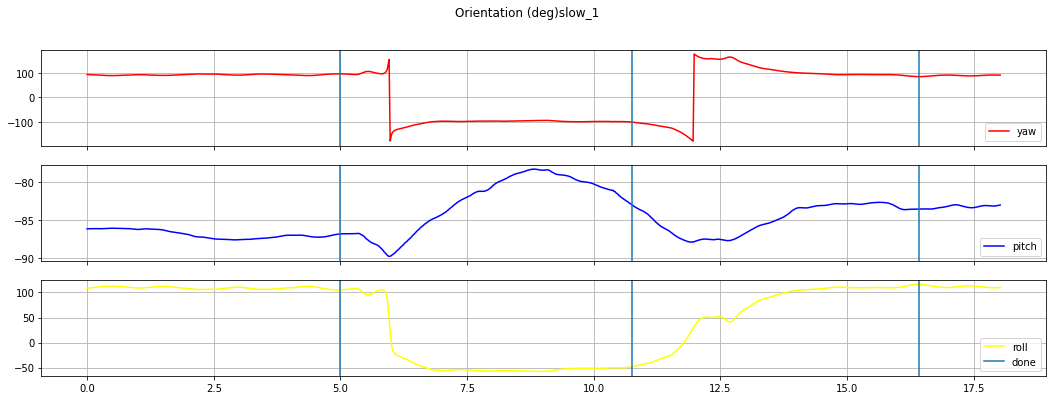

In [ ]:
fig, ax = plt.subplots(3, figsize=(18,6), sharex=True)

ax[0].plot(imu[:,0], imu[:,1], label='yaw', color='red')
ax[0].legend(loc='lower right')

ax[1].plot(imu[:,0], imu[:,2], color='blue', label='pitch')
ax[1].legend(loc='lower right')

ax[2].plot(imu[:,0], imu[:,3], color='yellow', label='roll')
for a in ax:
    for time, label in times.items():
        a.axvline(x=time, label=(label if label != '' else None))
ax[2].legend(loc='lower right')
for a in ax:
    a.grid()



fig.suptitle("Orientation (deg)" + run_name);

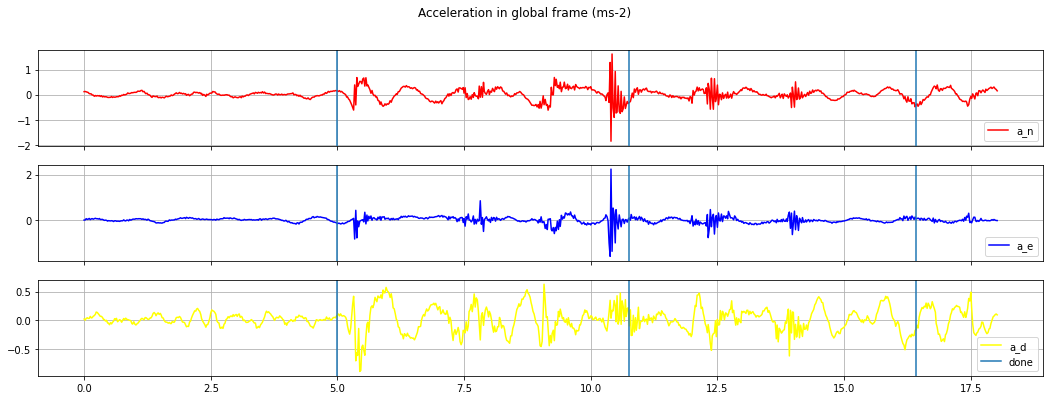

In [ ]:
fig, ax = plt.subplots(3, figsize=(18,6), sharex=True)

acc = imu[:, 4:7] #- imu[:, 4:7].mean(axis=0)

ax[0].plot(imu[:,0], acc[:,0], color='red', label='a_n')
ax[0].legend(loc='lower right')
ax[1].plot(imu[:,0], acc[:,1], color='blue', label='a_e')
ax[1].legend(loc='lower right')
ax[2].plot(imu[:,0], acc[:,2], color='yellow', label='a_d')
for a in ax:
    for time, label in times.items():
        a.axvline(x=time, label=(label if label != '' else None))
ax[2].legend(loc='lower right')
for a in ax:
    a.grid()

fig.suptitle("Acceleration in global frame (ms-2)");

Find 

# Remove Initial Deviation

In [ ]:
win_rest = slice(0, int(fs * sorted(times.keys())[0]))

In [ ]:
zero_state = imu[win_rest, 1:].mean(axis=0)

In [ ]:
zero_state

array([ 9.26010000e+01, -8.68458320e+01,  1.09142576e+02,  6.77000000e-03,
        1.56460000e-02,  2.03640000e-02])

In [ ]:
imu_dev = imu[:, 1:] - zero_state

'pitch'

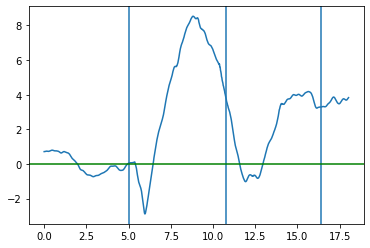

In [ ]:
plt.plot(imu[:, 0], imu_dev[:, 1])
plt.axvline(sorted(times.keys())[0])
plt.axvline(sorted(times.keys())[1])
plt.axvline(sorted(times.keys())[2])
plt.axhline(0, color='green')
"pitch"

'roll'

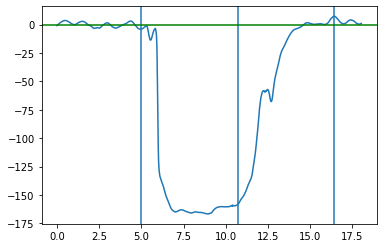

In [ ]:
plt.plot(imu[:, 0], imu_dev[:, 2])
plt.axvline(sorted(times.keys())[0])
plt.axvline(sorted(times.keys())[1])
plt.axvline(sorted(times.keys())[2])
plt.axhline(0, color='green')
"roll"

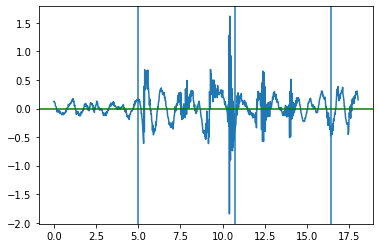

In [ ]:
plt.plot(imu[:, 0], imu_dev[:, 3])
plt.axvline(sorted(times.keys())[0])
plt.axvline(sorted(times.keys())[1])
plt.axvline(sorted(times.keys())[2])
plt.axhline(0, color='green')

In [ ]:
import numpy as np

def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [ ]:
acc_std = np.std(rolling_window(imu_dev[:, 3:6], int(fs*0.5)), axis=-1)[:-1, ...]

(0.0, 2.0)

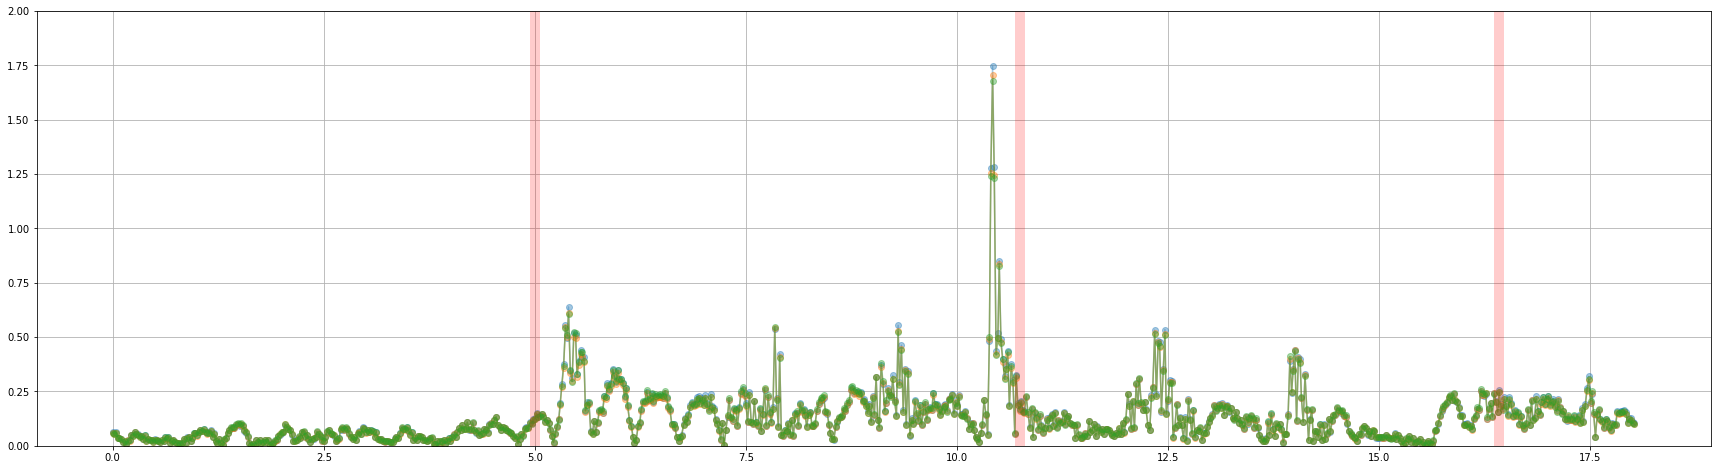

In [ ]:
plt.figure(figsize=(30,8))
plt.plot(imu[:, 0], acc_std, 'o-', alpha=0.4)
# plt.plot(imu[:, 0], acc_std, 'o-', c=(acc_std > 0.15).astype(int), alpha=0.4)
for t in sorted(times.keys()):
    plt.axvline(t, color='red', linewidth=10, alpha=0.2)
plt.grid()
plt.ylim(0,2)

# Test the effects

In [ ]:
vel = np.cumsum(imu_dev[:, 3:6], axis=0) * dt

In [ ]:
plt.figure(figsize=(30,8))
plt.plot(imu[:, 0], vel, '-',)
for t in sorted(times.keys()):
    plt.axvline(t, color='red', linewidth=10, alpha=0.2)
plt.grid()

In [ ]:
start_time = sorted(times.keys())[0] - 1
end_time = sorted(times.keys())[-1]

In [ ]:
vel_start = vel[int(start_time * fs)]
vel_end = vel[int(end_time * fs)]

In [ ]:
vel_cor = vel.copy()
vel_cor[int(start_time * fs):int(end_time * fs), ...] -= (vel_start[None, :] + (vel_end - vel_start)[None, :] * np.arange(int(end_time * fs) - int(start_time * fs))[:, None] / (int(end_time * fs) - int(start_time * fs)))
vel_cor[int(end_time * fs):, ...] -= vel_end

In [ ]:
plt.figure(figsize=(30,8))
plt.plot(imu[:, 0], vel_cor, '-',)
for t in sorted(times.keys()):
    plt.axvline(t, color='red', linewidth=10, alpha=0.2)
plt.grid()

In [ ]:
pos = np.cumsum(vel, axis=0) * dt
pos_cor = np.cumsum(vel_cor, axis=0) * dt

In [ ]:
plt.figure(figsize=(30,8))
plt.plot(imu[:, 0], pos, '-',)
for t in sorted(times.keys()):
    plt.axvline(t, color='red', linewidth=10, alpha=0.2)
plt.grid()

In [ ]:
plt.figure(figsize=(30,8))
plt.plot(imu[:, 0], pos_cor, '-',)
for t in sorted(times.keys()):
    plt.axvline(t, color='red', linewidth=10, alpha=0.2)
plt.grid()

# Find zero_velocity

In [ ]:
imu_dev[:, 0:3] = np.rad2deg(np.unwrap(np.deg2rad(imu_dev[:, 0:3]), axis=0))

In [ ]:
import numpy as np

def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [ ]:
acc_std = np.std(rolling_window(imu_dev[:, 3:6], int(fs*0.5)), axis=-1)[:-1, ...] / 2 
angles = np.abs(imu_dev[:, 1:3] / 180)

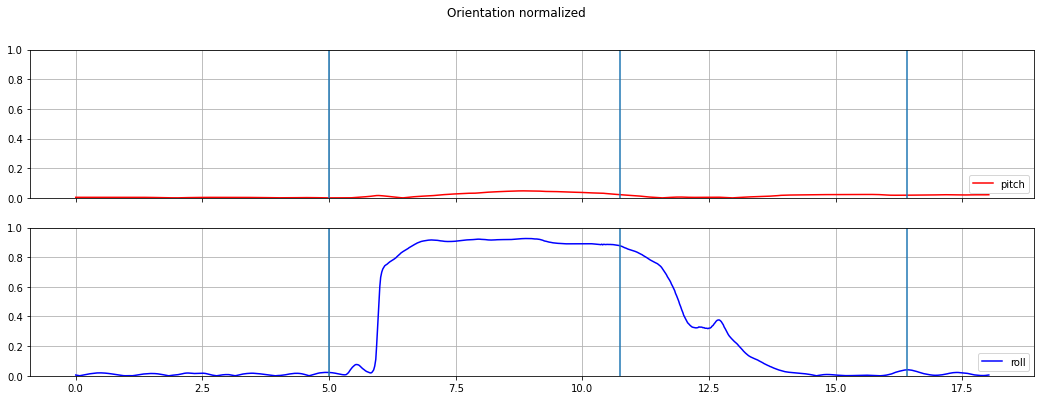

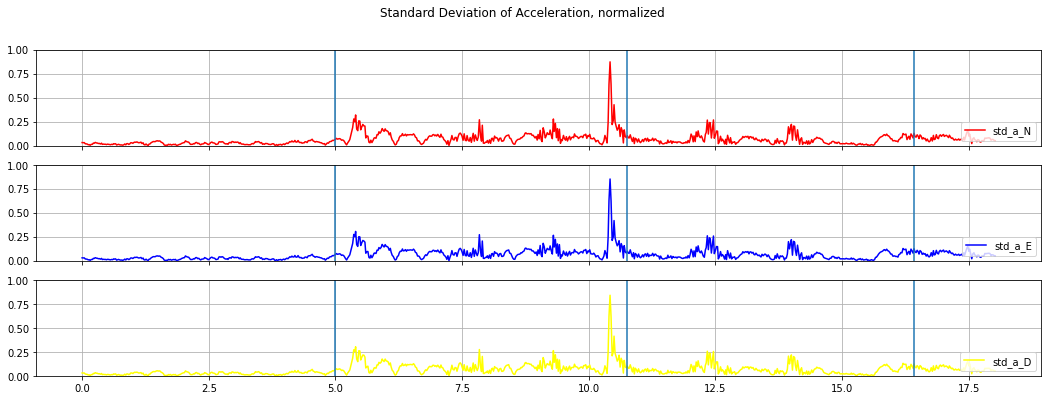

In [ ]:
fig, ax = plt.subplots(2, figsize=(18,6), sharex=True)

ax[0].plot(imu[:,0], angles[:,0], label='pitch', color='red')
ax[0].legend(loc='lower right')

ax[1].plot(imu[:,0], angles[:,1], color='blue', label='roll')
ax[1].legend(loc='lower right')

for a in ax:
    for time, label in times.items():
        a.axvline(x=time)  #, label=(label if label != '' else None))

for a in ax:
    a.grid()
    a.set_ylim(0, 1)

fig.suptitle("Orientation normalized");


fig, ax = plt.subplots(3, figsize=(18,6), sharex=True)

ax[0].plot(imu[:,0], acc_std[:,0], label='std_a_N', color='red')
ax[0].legend(loc='lower right')

ax[1].plot(imu[:,0], acc_std[:,1], color='blue', label='std_a_E')
ax[1].legend(loc='lower right')

ax[2].plot(imu[:,0], acc_std[:,2], color='yellow', label='std_a_D')
for a in ax:
    for time, label in times.items():
        a.axvline(x=time)#, label=(label if label != '' else None))
ax[2].legend(loc='lower right')
for a in ax:
    a.grid()
    a.set_ylim(0, 1)

fig.suptitle("Standard Deviation of Acceleration, normalized");

In [ ]:
features = np.hstack((angles, acc_std))

## Try PCA?

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(np.hstack((imu_dev[:, 0:3], acc_std)))

In [ ]:
start_time = sorted(times.keys())[0]
end_time = sorted(times.keys())[-1]

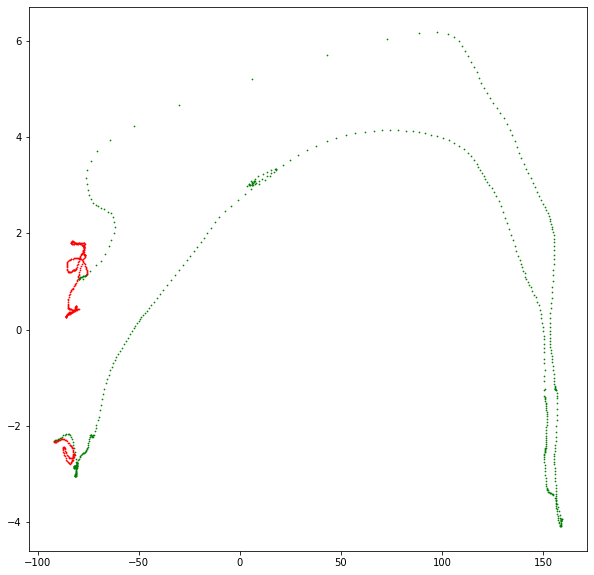

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(*(pca_data[(imu[:, 0] > start_time)&(imu[:, 0] < end_time), :].T), color='green', s=0.5)
plt.scatter(*(pca_data[~((imu[:, 0] > start_time)&(imu[:, 0] < end_time)), :].T), color='red', s=0.5)

'So this is basically just one axis of Pitch, and one of roll + yaw, its uselsess'

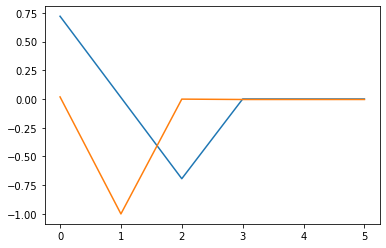

In [ ]:
plt.plot(pca.components_.T)
pca.components_, "So this is basically just one axis of Pitch, and one of roll + yaw, its uselsess"

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
pca1d = PCA(n_components=1)
pca_data1d = pca1d.fit_transform(np.hstack((imu_dev[:, 0:3], acc_std)))

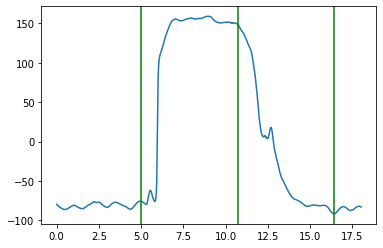

In [ ]:
plt.plot(imu[:, 0], pca_data1d)
for time, label in times.items():
    plt.axvline(x=time, color='green')#, label=(label if label != '' else None))

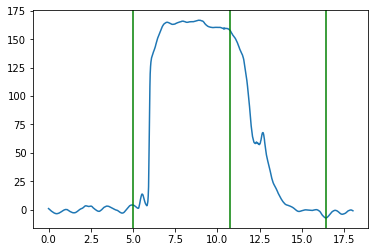

In [ ]:
plt.plot(imu[:, 0], -imu_dev[:, 2])
for time, label in times.items():
    plt.axvline(x=time, color='green')#, label=(label if label != '' else None))

(array([[ 7.20482680e-01,  1.38766419e-02, -6.93333785e-01,
          3.75397483e-04,  3.63974310e-04,  3.68985548e-04]]),
 'So this is basically just one axis of Pitch, and one of roll + yaw, its uselsess')

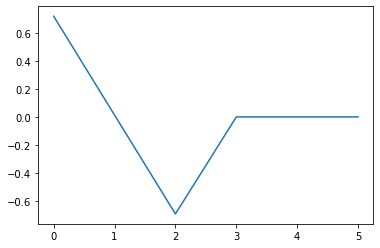

In [ ]:
plt.plot(pca1d.components_.T)
pca1d.components_, "So this is basically just one axis of Pitch, and one of roll + yaw, its uselsess"

In [ ]:
(np.hstack((imu_dev[:, 0:3], acc_std)) @ pca1d.components_.T).shape

(902, 1)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
pca1d = PCA(n_components=1)
pca_data1d = pca1d.fit_transform(normalize(np.hstack((imu_dev[:, 0:3], acc_std))))

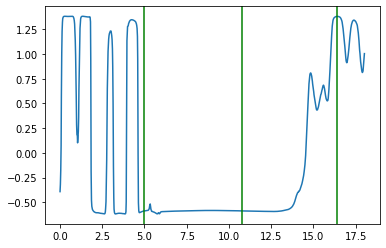

In [ ]:
plt.plot(imu[:, 0], pca_data1d)
for time, label in times.items():
    plt.axvline(x=time, color='green')#, label=(label if label != '' else None))

In [ ]:
pca1d.components_, "Better components, but useless"

array([[-0.69411825,  0.23010949,  0.68188963,  0.00970222,  0.00945501,
         0.00961646]])

## Dont use pca

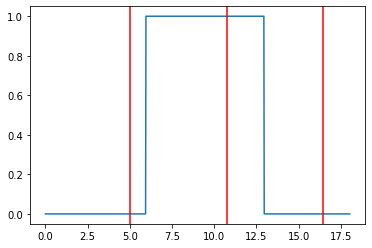

In [ ]:
plt.plot(imu[:, 0], (np.linalg.norm(features[:, 0:2], axis=1) > 0.25).astype(int))
for time, label in times.items():
    plt.axvline(x=time, color='red')#, label=(label if label != '' else None))

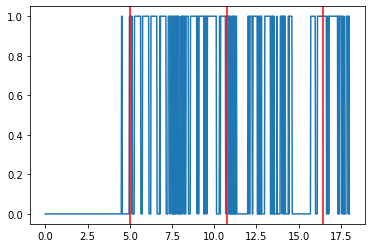

In [ ]:
plt.plot(imu[:, 0], np.linalg.norm(features[:, 2:5], axis=1) > 0.1)
for time, label in times.items():
    plt.axvline(x=time, color='red')#, label=(label if label != '' else None))

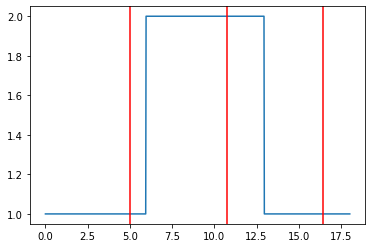

In [ ]:
plt.plot(imu[:, 0], (np.linalg.norm(features[:, 0:2], axis=1) > 0.25).astype(int) + (np.linalg.norm(features[:, 2:5], axis=1) > 0.).astype(int))
for time, label in times.items():
    plt.axvline(x=time, color='red')#, label=(label if label != '' else None))

# Use Metric

In [ ]:
zero_state = imu[slice(0, int(fs * 5)), 2:4].mean(axis=0)
imu_dev = imu[:, 2:4] - zero_state
imu_dev = np.rad2deg(np.unwrap(np.deg2rad(imu_dev), axis=0))
imu_dev = np.abs(imu_dev / 180)
in_motion = np.linalg.norm(imu_dev, axis=1) > 0.25
# in_motion = imu_dev[:, 0] > 0.025

Text(0, 0.5, 'Deviation (rad / pi)')

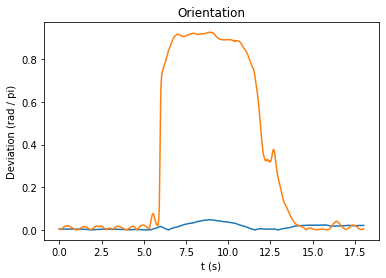

In [ ]:
plt.plot(imu[:, 0], imu_dev)
plt.title('Orientation')
plt.xlabel('t (s)')
plt.ylabel('Deviation (rad / pi)')

Text(0.5, 0, 't (s)')

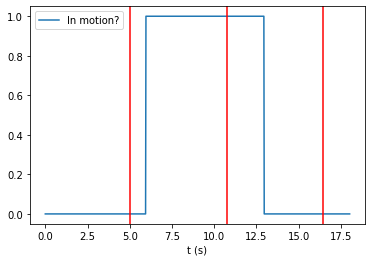

In [ ]:
plt.plot(imu[:, 0], in_motion, label="In motion?")
plt.legend()
for time, label in times.items():
    plt.axvline(x=time, color='red')#, label=(label if label != '' else None))
plt.xlabel('t (s)')


In [ ]:
all_indices = np.where(np.diff(in_motion))[0]
all_indices = all_indices[:len(all_indices) - (len(all_indices)%2)]
all_indices = np.insert(all_indices, 0, 0)
all_indices = np.insert(all_indices, all_indices.shape[0], in_motion.shape[0])

In [ ]:
zero_state = imu[slice(0, int(fs * 5)), 4:7].mean(axis=0)
acc_dev = imu[:, 4:7] - zero_state

In [ ]:
vel = np.cumsum(acc_dev[:, :], axis=0) * dt
vel_cor = vel.copy()
indices = all_indices

zero_state = True
zero_vel = vel_cor[indices[0]:indices[1]].mean(axis=0)
for i in range(len(indices) - 1):
    if zero_state:
        # vel_cor[indices[i]:indices[i+1]] -= zero_vel
        vel_cor[indices[i]:indices[i+1]] = 0
        vel_cor[indices[i+1]:] -= zero_vel
    else:
        zero_vel = vel_cor[indices[i+1]:indices[i+2]].mean(axis=0)
        vel_cor[indices[i]:indices[i+1], ...] -= vel_cor[indices[i]+1]
        vel_cor[indices[i]:indices[i+1], ...] -= (vel_cor[indices[i+1]-1] * np.linspace(0, 1, indices[i+1] - indices[i])[:, None])
    zero_state = not zero_state

Text(0, 0.5, 'Vel (ms-1)')

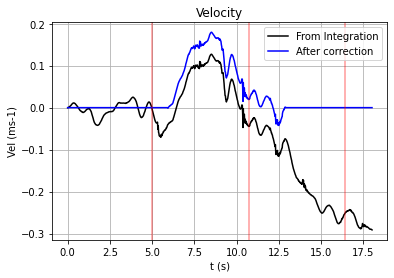

In [ ]:
plt.plot(imu[:, 0], vel[:, 1], color='black', label='From Integration')
plt.plot(imu[:, 0], vel_cor[:, 1], color='blue', label='After correction')
plt.grid()
plt.legend()
for time, label in times.items():
    plt.axvline(x=time, color='red', alpha=0.4)#, label=(label if label != '' else None))
plt.title('Velocity')
plt.xlabel('t (s)')
plt.ylabel('Vel (ms-1)')

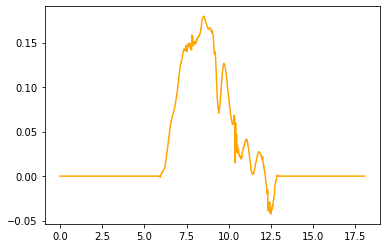

In [ ]:
plt.plot(imu[:, 0], vel_cor[:, 1], color='orange')

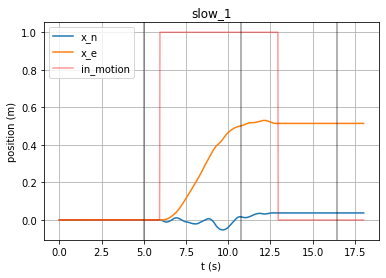

In [ ]:
# plt.figure(figsize=(20,6))
plt.title(run_name)

for v, label in zip(vel_cor.T[:2], ('x_n', 'x_e', 'x_d')):
    plt.plot(imu[:, 0], np.cumsum(v, axis=0) * dt, label=label)

plt.plot(imu[:, 0], in_motion, color='red', label='in_motion', alpha=0.4)

for time, label in times.items():
    plt.axvline(x=time, color='black', alpha=0.4)#, label=(label if label != '' else None))

plt.legend()
plt.grid()
plt.xlabel('t (s)')
plt.ylabel('position (m)')
plt.show()


# Plots: Use imu_0

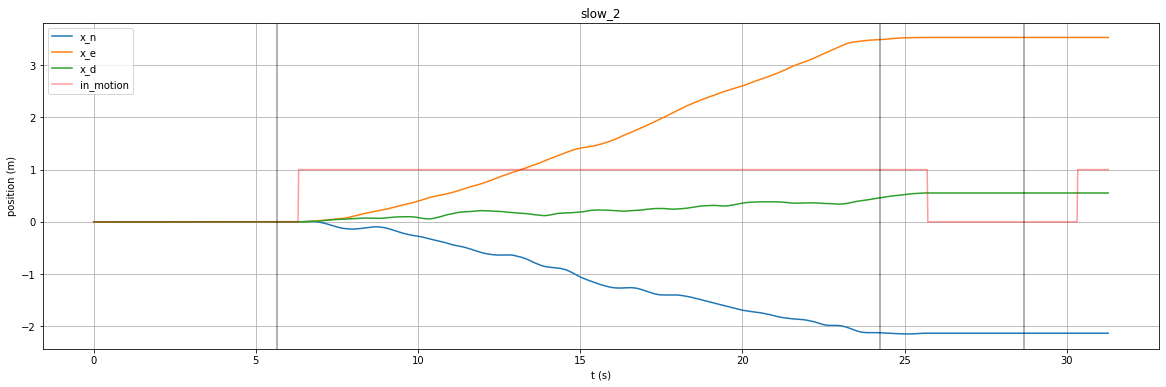

# Proper vel zeroing 

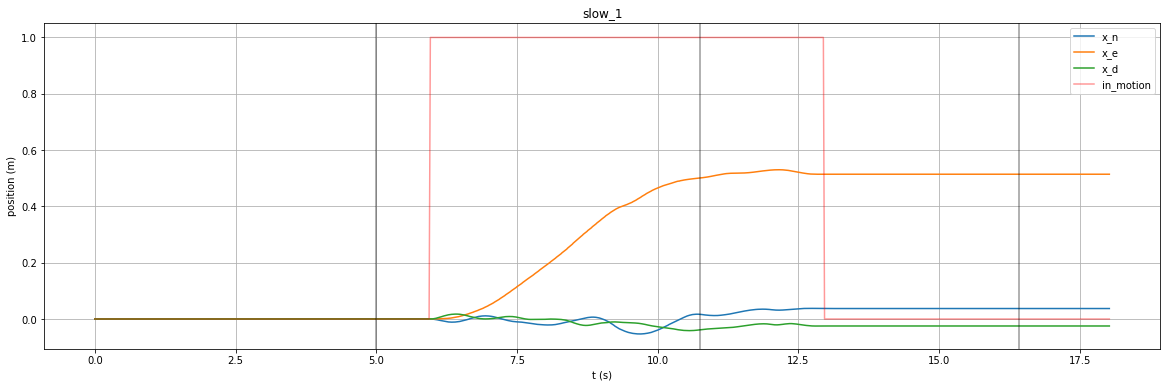

# Old velocity zeroin


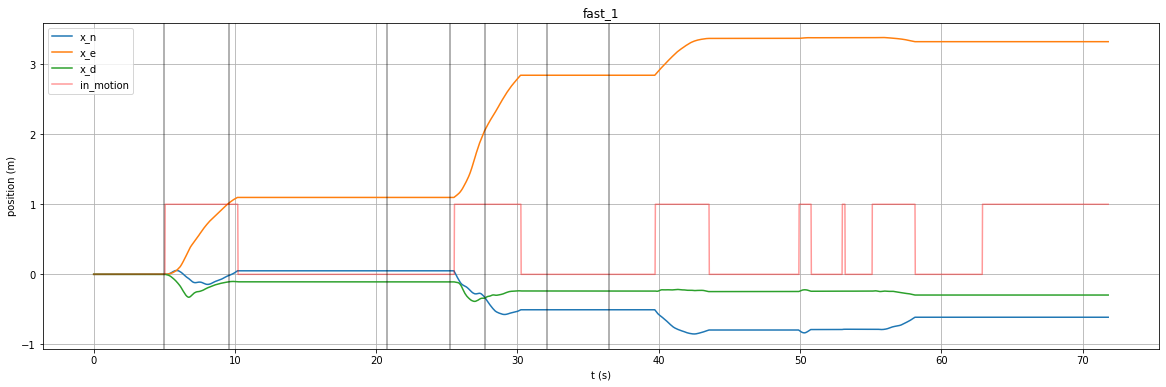

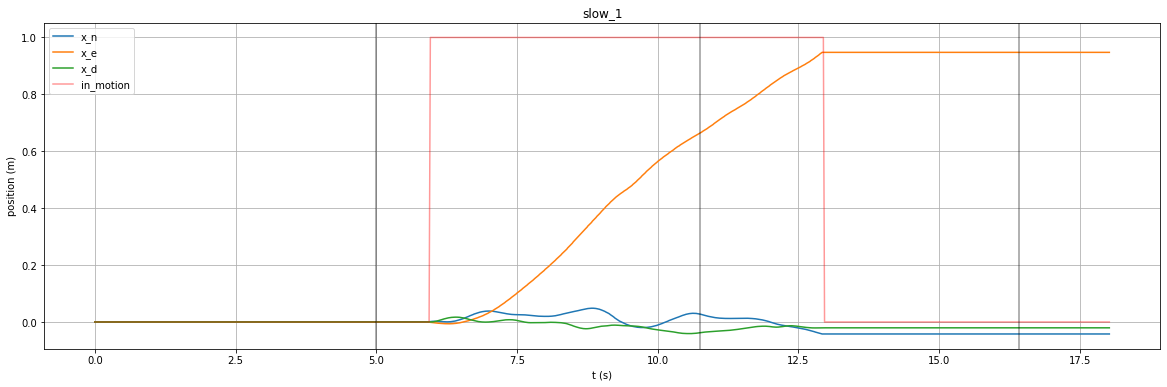